# Imports

In [1]:
from scipy.stats import *
from scipy.special import *
import numpy as np
import matplotlib.pyplot as plt
import copy

# Plot methods

In [2]:
def draw_ellipse(position, covariance, cm, label, ax=None, **kwargs):
# def draw_ellipse(position, covariance, ax=None, **kwargs):
    from matplotlib.patches import Ellipse
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    plt.plot()
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, facecolor=cm(label), alpha=0.8*1/nsig))

def plot_gmm_approx(elbos, mk, wk_inv, vk, pi_trunc, samples, thres=1e-3, figsize=(10,20)):
    f, ax =plt.subplots(1, 2, figsize=figsize)
    
    for sample in samples:
        ax[0].scatter(sample[:, 0], sample[:,1])
    
    for i in range(n_mixtures):
        if pi_trunc is not None and pi_trunc[i] < thres: continue
        precision = e_lambda(wk_inv, vk, i)
        cov = np.linalg.inv(precision)
        ax[0].scatter(mk[i, 0], mk[i, 1], c='black')
        cm = plt.cm.get_cmap('viridis_r', 7)
        draw_ellipse(mk[i, :], cov, cm, i, ax=ax[0])
    ax[1].plot(range(len(elbos)), elbos)
    plt.show()

# Auxiliar functions

In [44]:
def wishart_log_norm_const(v, w):
    D = w.shape[1]
    aux = 0
    for j in range(1, D+1):
        aux += gammaln(.5*v -.5*(j-1))
    multi_gamma = (D*(D-1)/4)*np.log(np.pi) + aux
    return -.5*v*D*np.log(2) -.5*v*log_e(np.linalg.det(w))-multi_gamma

def log_norm_beta(alphak1, alphak2):
    return gammaln(alphak1) + gammaln(alphak2) - gammaln(alphak1+alphak2)

def softmax(unnormalized):
    e_x = np.exp(unnormalized - np.max(unnormalized))
    return (e_x+np.finfo(np.float32).eps) / (e_x.sum()+np.finfo(np.float32).eps)

def e_pi_log(alphak, k):
    return psi(alphak[k] + np.finfo(np.float32).eps) - psi(np.sum(alphak))

def e_lambda_log_det(vk, wk_inv, k):
    D = wk_inv.shape[1]
    wk = np.linalg.inv(wk_inv[k, :, :])
    det_wk = np.linalg.det(wk)
    sum_psi = 0
    for i in range(1, D+1):
        sum_psi += psi((vk[k]+1-i)/2.0) 
    return sum_psi + float(D)*np.log(2) + log_e(det_wk)

def e_lambda(wk_inv, vk, k):
    wk = np.linalg.inv(wk_inv[k, :, :])
    return vk[k]*wk

def dirichlet_expectation(alphak):
    return alphak/np.sum(alphak)

def e_log_beta(alphak1, alphak2, k):
    return psi(alphak1[k]) - psi(alphak1[k]+alphak2[k])
    
def e_log_1_minus_beta(alphak1, alphak2, k):
    return psi(alphak2[k]) - psi(alphak1[k]+alphak2[k])

def e_beta(alphak1, alphak2, k):
    return alphak1[k]/(alphak1[k]+alphak2[k])

def e_pi_trunc(alphak1, alphak2):
    e_pi = list()
    n_mixtures = alphak1.shape[0]
    for k in range(n_mixtures):
        e_vk = e_beta(alphak1, alphak2, k)
        e_1_vk = 1
        for t in range(k):
            e_1_vk *= (1-e_beta(alphak1, alphak2, t))
        e_pi.append(e_vk*e_1_vk)
    rem = 1 - np.sum(e_pi)
    e_pi.append(rem)
    return np.array(e_pi)

def e_alpha_gamma(w1, w2):
    return w1/w2

def e_log_alpha_gamma(w1, w2):
    return psi(w1) - log_e(w2)


# Update for variational parameters

In [45]:
def update_r_z(r_probs, alphak1, alphak2, mk, bk, vk, wk_inv, data):
    D, n_data = data.shape
    n_mixtures = r_probs.shape[0]
    for n in range(n_data):
        rho_n = np.zeros((n_mixtures)) 
        for k in range(n_mixtures):
            xn = data[:, n]
            m = xn - mk[k,:]
            wk = np.linalg.inv(wk_inv[k,:,:])
            aux = D/bk[k] + vk[k]*np.dot(np.dot(m.T, wk), m)
            if k != n_mixtures-1:
                e_vk = e_log_beta(alphak1, alphak2, k)
            else: 
                e_vk = 0
            e_1_vk = 0
            for t in range(k):
                e_1_vk += e_log_1_minus_beta(alphak1, alphak2, t)
            rho_n[k] = -(D/2.)*np.log(2*np.pi) + e_vk + e_1_vk + .5*e_lambda_log_det(vk, wk_inv, k) - .5*aux
        r_probs[:, n] = softmax(rho_n)
    return r_probs

# Parameters Alpha-K1 and Alpha-K2 of Beta distributions.
def update_alphak1_v(alphak1, r_probs):
    n_mixtures = alphak1.shape[0]
    for k in range(n_mixtures):
        alphak1[k] = np.sum(r_probs[k, :])
    return alphak1

def update_alphak2_v(alphak2, w1, w2, r_probs):
    n_mixtures = alphak2.shape[0]
    for k in range(n_mixtures):
        alphak2[k] = e_alpha_gamma(w1, w2) + np.sum(r_probs[k+1:, :])
    return alphak2
    
def update_mk_mean(mk, mo, bo, bk, r_probs, data):
    D, n_data = data.shape
    n_mixture = mk.shape[0]
    for k in range(n_mixture):
        aux = np.zeros((D))
        for n in range(n_data):
            x_n = data[:,n]
            aux += r_probs[k, n]*x_n
        mk[k, :] = (mo[k, :]*bo[k] + aux)/bk[k]
    return mk

def update_bk_mean(bk, bo, r_probs):
    n_mixture = bk.shape[0]
    for k in range(n_mixture):
        bk[k] = bo[k] + np.sum(r_probs[k, :])
    return bk

def update_vk_lambda(vk, vo, r_probs):
    n_mixture = vk.shape[0]
    for k in range(n_mixtures):
        vk[k] = vo[k] + np.sum(r_probs[k, :])
    return vk
            
def update_wk_inv_lambda(wk_inv, wo_inv, mk, mo, bk, bo, r_probs, data):
    n_mixtures = wk_inv.shape[0]
    D, n_data = data.shape
    for k in range(n_mixtures):
        aux = np.zeros((D, D))
        for n in range(n_data):
            x_n = data[:,n]
            aux += r_probs[k, n]*np.outer(x_n,x_n.T)
        wk_inv[k,:,:] = wo_inv[k, :, :]
        wk_inv[k,:,:] +=  bo[k]*np.outer(mo[k,:], mo[k,:].T)
        wk_inv[k,:,:] += -bk[k]*np.outer(mk[k,:], mk[k,:].T)
        wk_inv[k,:,:] +=  aux
    return wk_inv

def update_w1_alpha(w1, T, bo_alpha):
    w1 = bo_alpha + T - 1
    return w1

def update_w2_alpha(w2, alphak1, alphak2, co_alpha):
    t_m_1_mixtures = alphak1.shape[0]
    aux = 0
    for k in range(t_m_1_mixtures):
        aux += e_log_1_minus_beta(alphak1, alphak2, k)
    w2 = co_alpha - aux
    return w2

# Evidence Lower Bound 

In [171]:
# ELBO  
def log_e(x):
    return np.log(x+np.finfo(np.float32).eps)

def compute_elbo(alphak1, alphak2, bo_alpha, co_alpha, w1, w2, r_probs, mk, bk, mo, bo, vk, wk_inv, vo, wo_inv, data):
    D, n_data = data.shape
    n_mixtures = mk.shape[0]
    
    q_a = w1*log_e(w2) - gammaln(w1) + (w1-1)*e_log_alpha_gamma(w1, w2) - w2*e_alpha_gamma(w1, w2)
    
    q_z = np.sum(r_probs*log_e(r_probs))
    
    # This is not right.
#     q_v = 0
#     for k in range(n_mixtures-1):
#         q_v += -log_norm_beta(alphak1[k], alphak2[k])
#         q_v += (alphak1[k]-1)*e_log_beta(alphak1, alphak2, k)
#         q_v += (alphak2[k]-1)*e_log_1_minus_beta(alphak1, alphak2, k)

    from scipy.stats import beta
    q_v = 0
    for k in range(n_mixtures-1):
        q_v += beta(a=alphak1[k], b=alphak2[k]).entropy()
        
    q_m_l = 0
    for k in range(n_mixtures):
        q_m_l += -.5*D*np.log(2*np.pi) + .5*D*log_e(bk[k]) + .5*e_lambda_log_det(vk, wk_inv, k)
        q_m_l += wishart_log_norm_const(vk[k], np.linalg.inv(wk_inv[k,:,:]))
        q_m_l += -.5*D +.5*(vk[k]-D-1)*e_lambda_log_det(vk, wk_inv, k)
        q_m_l += -.5*vk[k]*D
        
    p_a = bo_alpha*log_e(co_alpha) - gammaln(bo_alpha) + (bo_alpha-1)*e_log_alpha_gamma(w1, w2) 
    p_a +=  -co_alpha*e_alpha_gamma(w1, w2)
    
    p_z = 0
    for n in range(n_data):
        for k in range(n_mixtures):
            aux = 0
            if k != n_mixtures-1:
                aux = e_log_beta(alphak1, alphak2, k)
            for j in range(k):
                aux += e_log_1_minus_beta(alphak1, alphak2, j)
            p_z+= r_probs[k,n]*aux
            
    p_v = 0
    for k in range(n_mixtures-1):
        p_v += -log_norm_beta(1, e_alpha_gamma(w1, w2))
        p_v += (e_alpha_gamma(w1, w2)-1)*e_log_1_minus_beta(alphak1, alphak2, k)

    p_m_l = 0
    for k in range(n_mixtures):
        m = mk[k, :] - mo[k, :]
        wo = np.linalg.inv(wo_inv[k,:,:])
        aux = (bo[k]*D/bk[k]) + bo[k]*np.dot(m.T, np.dot(e_lambda(wk_inv, vk, k), m))
        p_m_l += -.5*D*np.log(2*np.pi) + .5*(D*log_e(bo[k]) + e_lambda_log_det(vk, wk_inv, k)) -.5*aux 
        p_m_l += wishart_log_norm_const(vo[k], wo)
        p_m_l += +.5*(vo[k]-D-1)*e_lambda_log_det(vk, wk_inv, k) -.5*np.trace(np.dot(wo_inv[k,:,:], e_lambda(wk_inv, vk, k)))
    
    p_x_given_z = 0
    for n in range(n_data):
        for k in range(n_mixtures):
            xn = data[:, n]
            m = xn - mk[k, :]
            aux = D/bk[k] + np.dot(m.T, np.dot(e_lambda(wk_inv, vk, k), m))
            p_x_given_z += r_probs[k,n]*(-.5*D*np.log(2*np.pi) + .5*e_lambda_log_det(vk, wk_inv, k) -.5*aux)

    # Having numerical stability when computing q_v_k entropies
#     print('q_z',q_z)
#     print('p_z',p_z)
#     print('----------')
#     print('q_v',q_v)
#     print('p_v',p_v)
#     print('----------')
#     print('q_m_l',q_m_l)
#     print('p_m_l',p_m_l)
#     print('----------')
#     print('p_x_given_z',p_x_given_z)
#     print()
    elbo = p_x_given_z + p_m_l + p_v + p_z + p_a - (q_m_l + q_v + q_z + q_a)
    return elbo

# Data

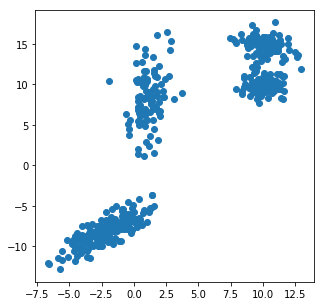

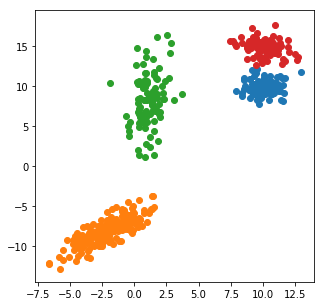

In [172]:
a = np.array([[3,2.5],[2.5,3]])
b = np.array([[.8,1],[1,10]])
# Prepare dataset
g1 = multivariate_normal(mean=[10, 10], cov=1)
g2 = multivariate_normal(mean=[-2, -8], cov=a)
g3 = multivariate_normal(mean=[1, 8], cov=b)
g4 = multivariate_normal(mean=[10, 15], cov=1)

samples = list()
samples.append(g1.rvs(100))
samples.append(g2.rvs(200))
samples.append(g3.rvs(100))
samples.append(g4.rvs(100))

data = np.vstack(samples)
data = data.T
data.shape

plt.figure(figsize=(5,5))
plt.scatter(data[0,:], data[1,:])
plt.show()
plt.figure(figsize=(5,5))
for sample in samples:
    plt.scatter(sample[:, 0], sample[:,1])

# Run optimization, maximize ELBO

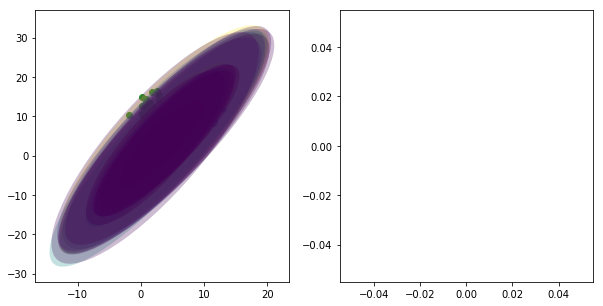

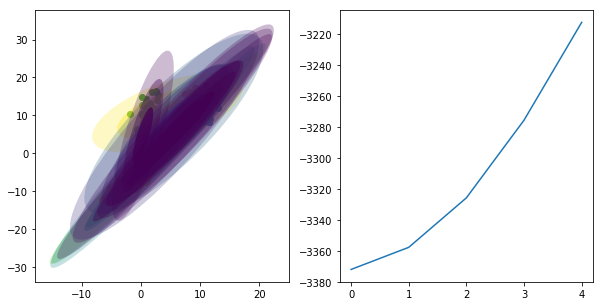

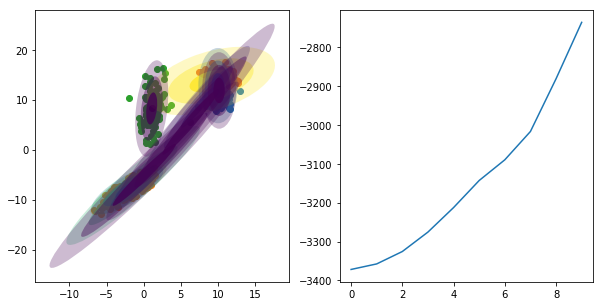

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


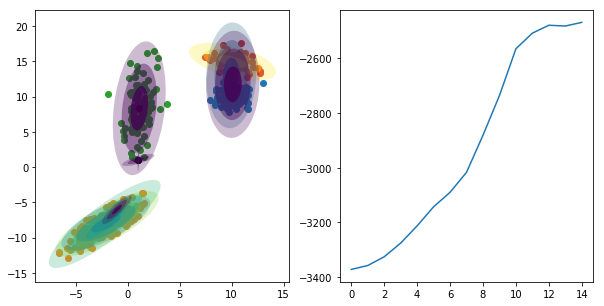

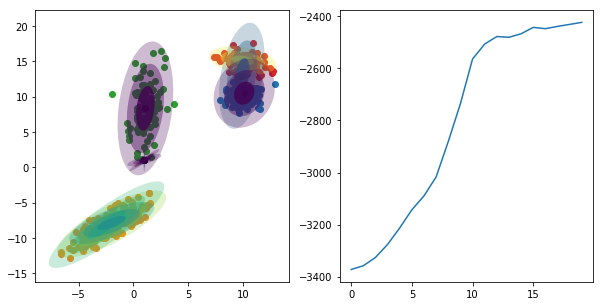

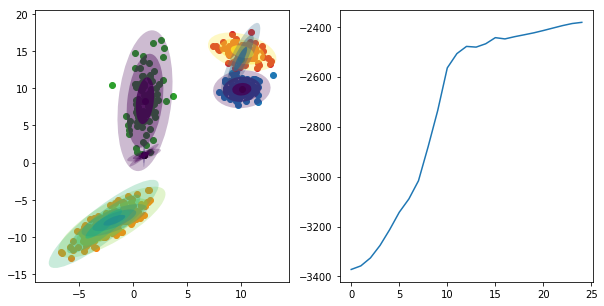

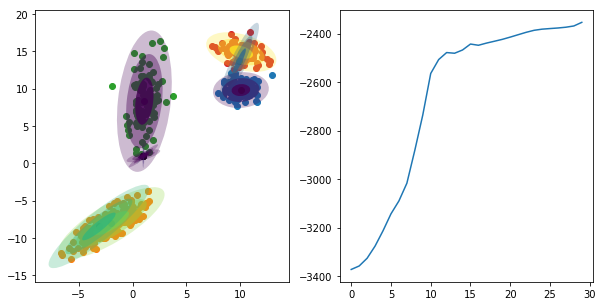

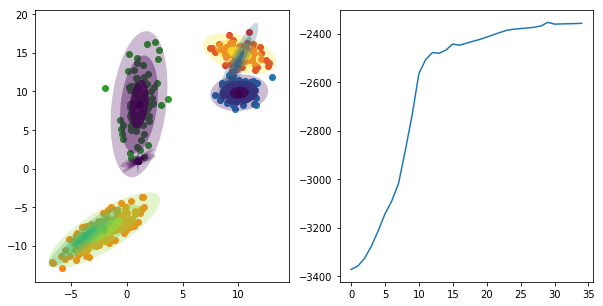

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


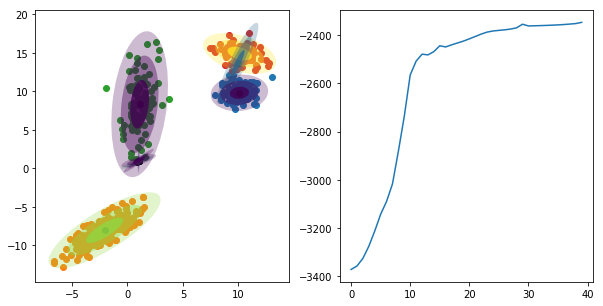

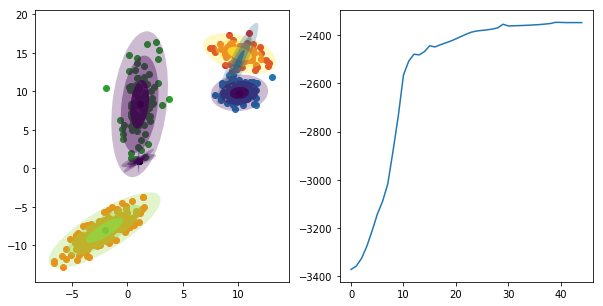

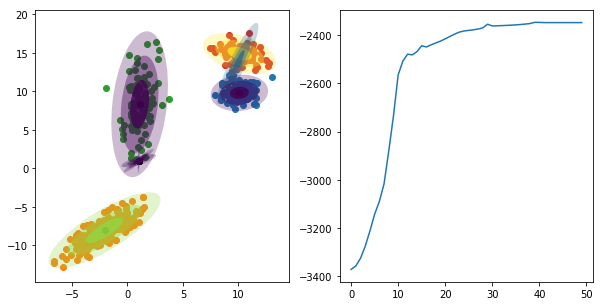

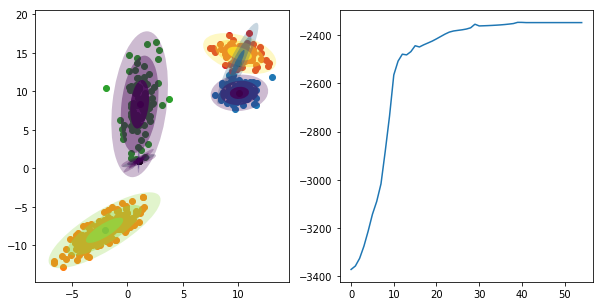

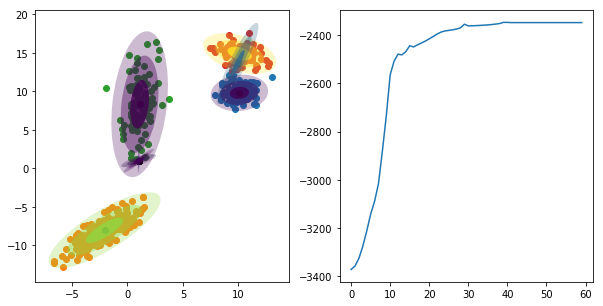

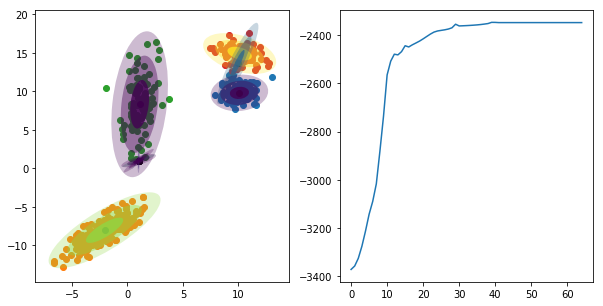

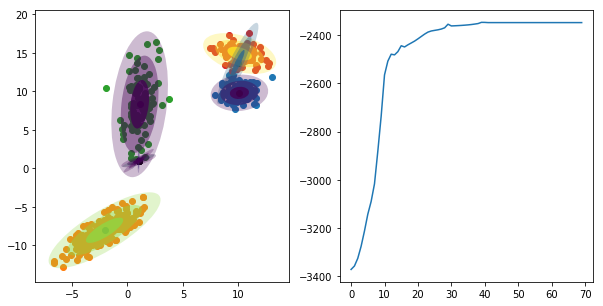

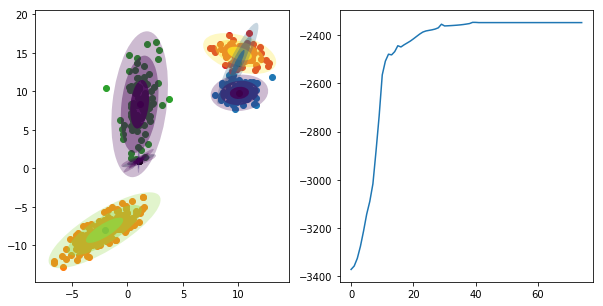

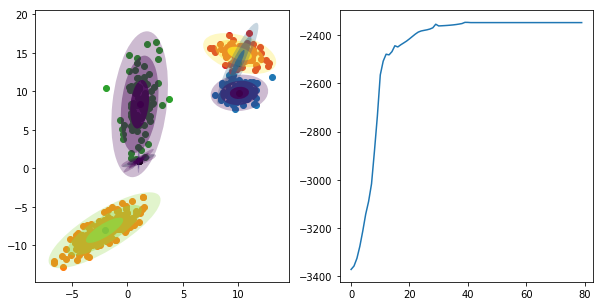

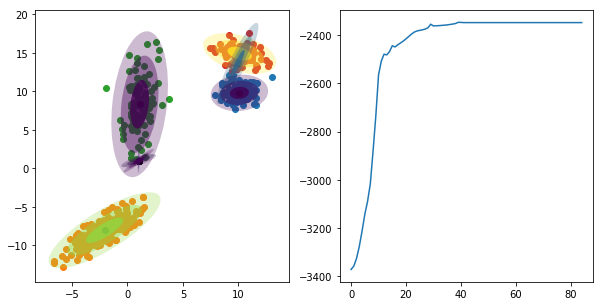

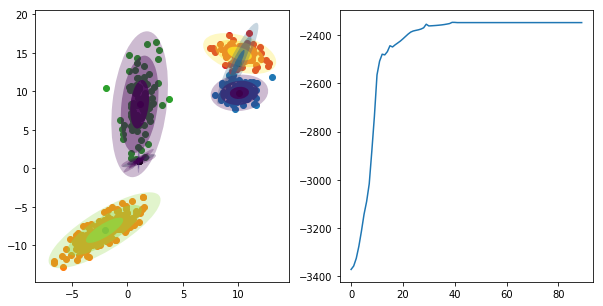

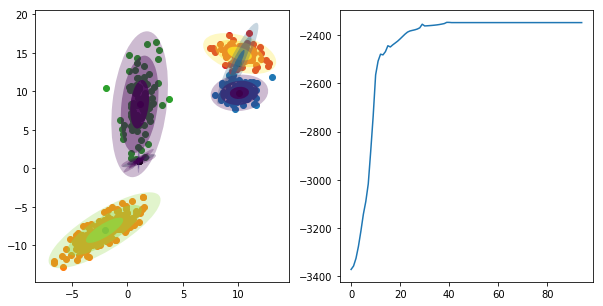

In [180]:
dimensionality = 2
n_mixtures = 10
n_data = data.shape[1]

## Priors 
# Alpha Gamma distribution.
bo_alpha = 1.
co_alpha = 1.

# Pi Dirichlet.
alpha = np.ones((n_mixtures-1), dtype=np.float64)*0.1

# Mean distribution.
mo = np.ones((n_mixtures, dimensionality), dtype=np.float64)
bo = 0.01*np.ones((n_mixtures), dtype=np.float64)

# Precision distribution.
vo = (dimensionality + 1)*np.ones((n_mixtures), dtype=np.float64)
wo_inv = np.zeros((n_mixtures, dimensionality, dimensionality), dtype=np.float64)
for k in range(n_mixtures):
    aux = np.random.rand(dimensionality, dimensionality)
    wo_inv[k,:,:] = np.dot(aux, aux.transpose())
    
## Inital values approximation parameters.
# Alpha Gamma distribution.
w1 = 1.
w2 = 1.

# Beta distributions.
alphak1 = np.zeros((n_mixtures-1), dtype=np.float64)
alphak2 = np.zeros((n_mixtures-1), dtype=np.float64)

# Z r_probs.
r_probs = np.random.dirichlet([0.1]*n_mixtures, n_data).T

# Mean distribution.
mk = np.zeros((n_mixtures, dimensionality), dtype=np.float64)
bk = np.zeros((n_mixtures), dtype=np.float64)

# Precision distribution.
vk = (dimensionality + 1)*np.ones((n_mixtures), dtype=np.float64)
wk_inv = np.zeros((n_mixtures, dimensionality, dimensionality), dtype=np.float64)
for k in range(n_mixtures):
    wk_inv[k,:,:] = np.eye(dimensionality)
    
elbos = list()
# Update parameters to maximize ELBO
for update in range(100): 
    
    alphak1 = update_alphak1_v(alphak1, r_probs)
    alphak2 = update_alphak2_v(alphak2, w1, w2, r_probs)
    bk = update_bk_mean(bk, bo, r_probs)
    vk = update_vk_lambda(vk, vo, r_probs)
    mk = update_mk_mean(mk, mo, bo, bk, r_probs, data)
    wk_inv = update_wk_inv_lambda(wk_inv, wo_inv, mk, mo, bk, bo, r_probs, data)    
    r_probs = update_r_z(r_probs, alphak1, alphak2, mk, bk, vk, wk_inv, data)
    w1 = update_w1_alpha(w1, n_mixtures, bo_alpha)
    w2 = update_w2_alpha(w2, alphak1, alphak2, co_alpha)
    
    current_elbo = compute_elbo(alphak1, alphak2, bo_alpha, co_alpha, w1, w2, r_probs, mk, bk, mo, bo, vk, wk_inv, vo, wo_inv, data)
    if update!=0 and abs(current_elbo-prev_elbo) < 1e-9: 
        print('Converged')
        break
    if update%5 == 0:
        plot_gmm_approx(elbos, mk, wk_inv, vk, None, samples, thres=1e-2, figsize=(10,5))
    elbos.append(current_elbo)
    prev_elbo = current_elbo


Pi (Gaussian weights):
	 [0.3969031341640621, 0.20616991445263055, 0.1864449267005628, 0.1751966167544982, 0.0352848307708802, 1.1543147322237041e-07, 1.154314732223704e-07, 1.154314732223704e-07, 1.154314732223704e-07, 1.1543147322237039e-07]
Alpha:
	 3.8716429636249714


Gaussian 1
	Weight:
		 0.3969031341640621
	Mean:
		 [-2.05484094 -8.02348788]
	Covariance:
		 [2.8234202  2.21204989]
		 [2.21204989 2.69783836]

Gaussian 9
	Weight:
		 0.20616991445263055
	Mean:
		 [1.1022743  8.33514132]
	Covariance:
		 [0.72157866 0.68321637]
		 [0.68321637 9.95726746]

Gaussian 7
	Weight:
		 0.1864449267005628
	Mean:
		 [10.08518025  9.80995622]
	Covariance:
		 [0.74539131 0.07015594]
		 [0.07015594 0.62324403]

Gaussian 0
	Weight:
		 0.1751966167544982
	Mean:
		 [10.10601345 14.91757007]
	Covariance:
		 [ 1.20392733 -0.3964382 ]
		 [-0.3964382   0.77825333]

Gaussian 4
	Weight:
		 0.0352848307708802
	Mean:
		 [ 9.92191176 13.62812222]
	Covariance:
		 [0.39141394 0.99522528]
		 [0.99522528 3.0962

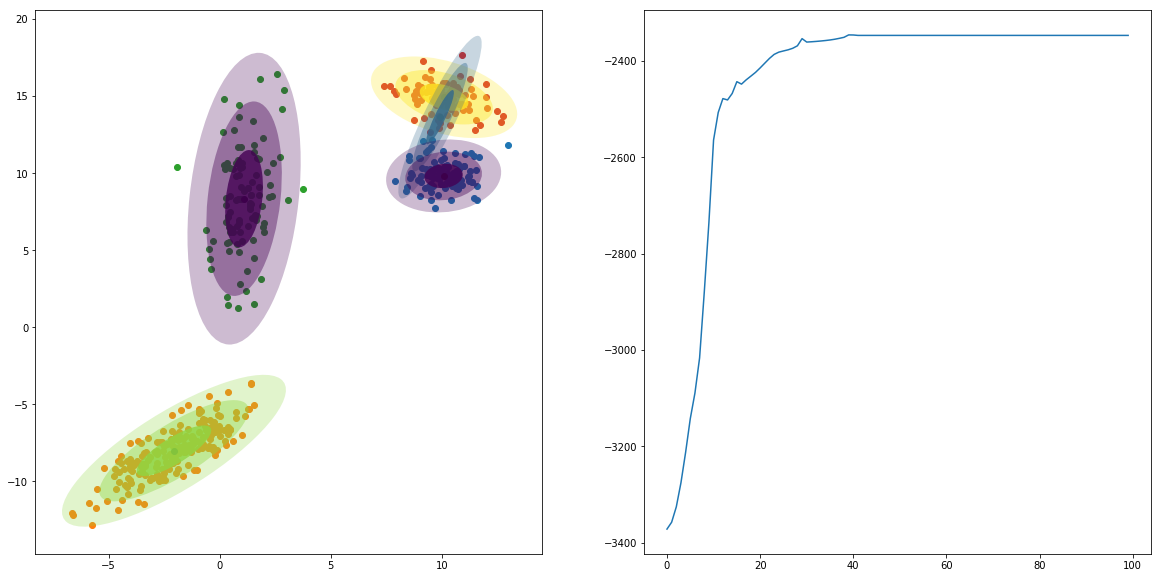

In [183]:
thres=1e-3
pi_trunc = e_pi_trunc(alphak1, alphak2)
print('Pi (Gaussian weights):')
print('\t', sorted(pi_trunc, reverse=True))

print('Alpha:')
print('\t', e_alpha_gamma(w1,w2))
print()
print()

for i in reversed(np.argsort(pi_trunc)):
    if pi_trunc[i] < thres: continue
    print('Gaussian', i)
    precision = e_lambda(wk_inv, vk, i)
    cov = np.linalg.inv(precision)
    print('\tWeight:')
    print('\t\t', pi_trunc[i])
    print('\tMean:')
    print('\t\t', mk[i, :])
    print('\tCovariance:')
    print('\t\t', cov[0, :])
    print('\t\t', cov[1, :])
    print()
print()

plot_gmm_approx(elbos, mk, wk_inv, vk, pi_trunc, samples, thres=1e-2, figsize=(20,10))
